# two asset ikc model

In [133]:
using ProgressMeter        # show progress of each loop with: @showprogress 1 "Computing..." for i in 1:50
using Parameters
using Interpolations
using Base.Threads
using Plots
using SparseArrays
include("functions.jl")

interpolate_coord (generic function with 1 method)

In [196]:

@with_kw mutable struct params
    # Households
    β::Float64  = 0.976    # Discount factor 
    σ::Float64  = 2        # Inverse IES
    χ0::Float64 = 0.25     # Portfolio adj. cost pivot 
    χ1::Float64 = 6.416    # Portfolio adj. cost scale 
    χ2::Float64 = 2        # Portfolio adj. cost curvature
    ρe::Float64 = 0.966    # Autocorrelation of earnings
    σe::Float64 = 0.92     # Cross-sectional std of log earnings
    μe::Float64 = 0.000    # mean of earnings
    min_a::Float64 = 0     # borrowing limit for illiquid asset
    min_b::Float64 = 0     # borrowing limit for liquid asset
    min_k::Float64 = 0     # min limit for kappa grid
    max_a::Float64 = 4000  # max limit for illiquid asset
    max_b::Float64 = 50    # max limit for liquid asset
    max_k::Float64 = 1     # max limit for kappa grid
    r::Float64  = 0.0125     # Real interest rate
    ζ::Float64  = 0.08/(1.05) # Illiquid-liquid spread
    # Labor Unions
    ϕ::Float64  = 2.073    # Disutility of labor
    ν::Float64  = 1        # Inverse Frisch elasticity
    μw::Float64 = 1.1      # Steady state wage markup
    κw::Float64 = 0.1      # Slope of wage Phillips curve
    # Firms
    Z::Float64  = 0.468    # TFP
    α::Float64  = 0.33     # Capital share
    μp::Float64 = 1.015    # Steady-state markup 
    δ::Float64  = 0.02     # Depreciation
    κp::Float64 = 0.1      # Slope of price Phillips curve 
    # # Financial intermediary
    # ω::Float64 = 0.005     # Liquidity premium
    # # policy
    # τ::Float64  = 0.356     # Labor tax
    # G::Float64  = 0.2       # Government spending
    # Bg::Float64 = 2.8       # Bond supply
    # Φ::Float64  = 1.5       # Taylor rule coefficien
    # Φy::Float64 = 0         # Taylor rule coefficient on output
    # Discretization
    na::Int = 70        # Number of grid points for illiquid asset
    nb::Int = 50        # Number of grid points for liquid asset
    nk::Int = 40        # Number of grid points for kappa
    nz::Int = 3         # Number of grid points for idiosyncratic income process 
end

pr = params(); #parameters of the model


In [197]:
# Initializing grids
a,b,k,z,z_p = grid_maker(pr)
z = z/2
pi = stationary(z_p)
y = exp.(z) ./ (pi'*exp.(z));

In [198]:
# initial guess
A_3d = reshape(a, (1, 1, length(a)))
B_3d = reshape(b, (1, length(b), 1))
Y_3d = reshape(y, (length(y), 1, 1))

Va = (0.6 .+       (A_3d.-pr.min_a) .+ 1.1 .* (B_3d.-pr.min_b) .+ 0.2 .* Y_3d) .^ (-pr.σ)
Vb = (0.5 .+ 1.2 .*(A_3d.-pr.min_a) .+        (B_3d.-pr.min_b) .+ 0.2 .* Y_3d) .^ (-pr.σ)

# precompute Psi1(a', a) on grid of (a', a) for steps 3 and 5
Psi, Psi1, Psi2 = get_Psi_and_deriv(a, a', pr);


## policy function solutions:

In [199]:
# EGM
@showprogress for i in 1:1000
    # === STEP 2: Wb(z, b', a') and Wa(z, b', a') ===
    # (take discounted expectation of tomorrow's value function)
    Wb = pr.β * reshape(z_p' * reshape(Vb, pr.nz, :), pr.nz, pr.nb, pr.na )
    Wa = pr.β * reshape(z_p' * reshape(Va, pr.nz, :), pr.nz, pr.nb, pr.na )
    W_ratio = Wa ./ Wb

    # === STEP 3: a'(z, b', a) for UNCONSTRAINED ===

    # for each (z, b', a), linearly interpolate to find a' between gridpoints
    # satisfying optimality condition W_ratio == 1+Psi1
    idx, pi = lhs_equals_rhs_interpolate(W_ratio, 1 .+ Psi1)
    # use same interpolation to get Wb and then c
    a_endo_unc = apply_coord(idx, pi, a)
    temp = similar(a_endo_unc)
    for i in 1:pr.nz
        @threads for j in 1:pr.nb
            temp[i,j,:] = apply_coord(idx[i,j,:], pi[i,j,:], Wb[i,j,:]).^ (-1/pr.σ)
        end
    end
    c_endo_unc = temp

    # === STEP 4: b'(z, b, a), a'(z, b, a) for UNCONSTRAINED ===
    # solve out budget constraint to get b(z, b', a)
    b_endo = (c_endo_unc + a_endo_unc + repeat(B_3d,pr.nz,1,pr.na) - repeat(A_3d.*(1+pr.r),pr.nz,pr.nb,1) - repeat(Y_3d,1,pr.nb,pr.na) + reshape(get_Psi_and_deriv(reshape(a_endo_unc,:,pr.na), a', pr)[1],pr.nz,pr.nb,pr.na) ) / ((1+pr.r)*(1-pr.ζ))

    # interpolate this b' -> b mapping to get b -> b', so we have b'(z, b, a)
    # and also use interpolation to get a'(z, b, a)
    # (note utils.interpolate.interpolate_coord and utils.interpolate.apply_coord work on last axis,
    #  so we need to swap 'b' to the last axis, then back when done)
    for i in 1:pr.nz
        @threads for j in 1:pr.na
            idx[i,:,j], pi[i,:,j] = interpolate_coord(b_endo[i,:,j],b)
        end
    end
    temp = similar(a_endo_unc)
    for i in 1:pr.nz
        @threads for j in 1:pr.na
            temp[i,:,j] = apply_coord(idx[i,:,j], pi[i,:,j], a_endo_unc[i,:,j])
        end
    end
    a_unc = temp
    b_unc = apply_coord(idx, pi, b);

    # === STEP 5: a'(z, kappa, a) for CONSTRAINED ===

    # for each (z, kappa, a), linearly interpolate to find a' between gridpoints
    # satisfying optimality condition W_ratio/(1+kappa) == 1+Psi1, assuming b'=0
    lhs_con = W_ratio[:, 1:1, :] ./ (1 .+ reshape(k,1,pr.nk,1))
    idx, pi = lhs_equals_rhs_interpolate(lhs_con, (1 .+ Psi1) )
    # use same interpolation to get Wb and then c
    a_endo_con = apply_coord(idx, pi, a)
    temp = similar(a_endo_con)
    for i in 1:pr.nz
        @threads for j in 1:pr.nk
            temp[i,j,:] = apply_coord(idx[i,j,:], pi[i,j,:], Wb[i, 1, :])
        end
    end
    c_endo_con = ( (1 .+ reshape(k,1,pr.nk,1)).^(-1/pr.σ) .* (temp).^(-1/pr.σ) )

    # === STEP 6: a'(z, b, a) for CONSTRAINED ===

    # solve out budget constraint to get b(z, kappa, a), enforcing b'=0
    b_endo_con = (c_endo_con + a_endo_con
              + repeat([b[1]],pr.nz,pr.nk,pr.na) - repeat(A_3d.*(1+pr.r),pr.nz,pr.nk,1) - repeat(Y_3d,1,pr.nk,pr.na)
              + reshape(get_Psi_and_deriv(reshape(a_endo_con,:,pr.na), a', pr)[1],pr.nz,pr.nk,pr.na) ) / ((1+pr.r)*(1-pr.ζ))
    # interpolate this kappa -> b mapping to get b -> kappa
    # then use the interpolated kappa to get a', so we have a'(z, b, a)
    # (utils.interpolate.interpolate_y does this in one swoop, but since it works on last
    # axis, we need to swap kappa to last axis, and then b back to middle when done)
    a_con = zeros(pr.nz, pr.nb, pr.na)
    for i in 1:pr.nz
        @threads for j in 1:pr.na
            a_con[i,:,j] = interpolate_f(b_endo_con[i,:,j], a_endo_con[i,:,j], b)
        end
    end

    # === STEP 7: obtain policy functions and update derivatives of value function ===

    # combine unconstrained solution and constrained solution, choosing latter
    # when unconstrained goes below minimum b
    a_pol = copy(a_unc) 
    b_pol = copy(b_unc)
    b_pol[b_pol .<= b[1]] .= b[1]
    a_pol[b_pol .<= b[1]] = a_con[b_pol .<= b[1]]
    # calculate adjustment cost and its derivative
    Psi, temp, Psi2 = get_Psi_and_deriv(reshape(a_pol,:,pr.na), a', pr)
    Psi  = reshape(Psi, pr.nz, pr.nb, pr.na)
    Psi2 = reshape(Psi2, pr.nz, pr.nb, pr.na)
    # solve out budget constraint to get consumption and marginal utility
    c_pol = repeat(B_3d.*(1+pr.r).*(1-pr.ζ),pr.nz,1,pr.na) + repeat(A_3d.*(1+pr.r),pr.nz,pr.nb,1) + repeat(Y_3d,1,pr.nb,pr.na) - Psi - a_pol - b_pol
    uc = c_pol .^ (-pr.σ)

    # update derivatives of value function using envelope conditions
    Va_new = (1 .+ pr.r .- Psi2) .* uc
    Vb_new = ((1+pr.r)*(1-pr.ζ)) .* uc

    if maximum(abs.(Va_new.-Va)) < 1e-9 && maximum(abs.(Vb_new.-Vb)) < 1e-9
        print("loop ended in iteration ",i)
        break
    end
    Va = copy(Va_new)
    Vb = copy(Vb_new)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


loop ended in iteration 624

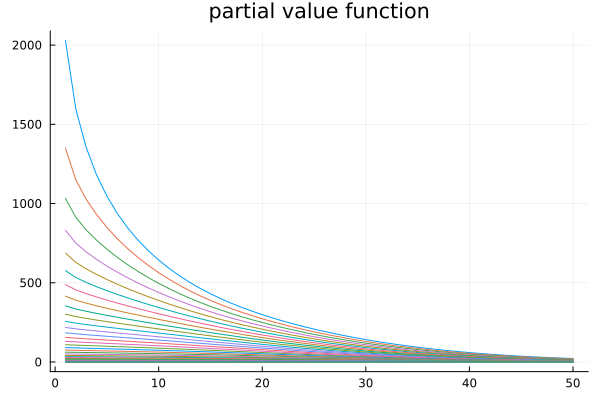

In [200]:
plot(Va[1,:,:], legend = false, title="partial value function")

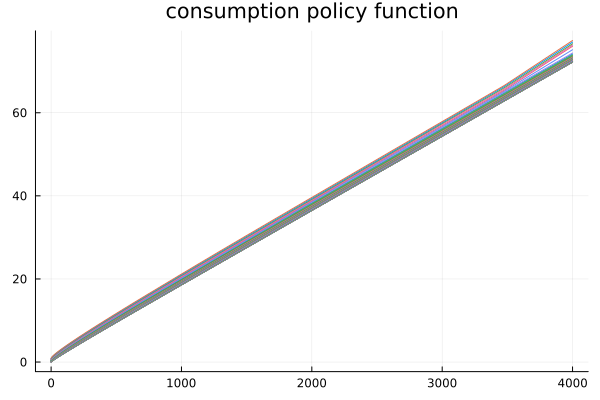

In [201]:
plot(a,c_pol[1,:,:]', legend = false, title="consumption policy function")
# c_pol[1,:,:]
# (repeat(B_3d.*(1+pr.r).*(1-pr.ζ),pr.nz,1,pr.na) + repeat(A_3d.*(1+pr.r),pr.nz,pr.nb,1) + repeat(Y_3d,1,pr.nb,pr.na) )[1,:,:]

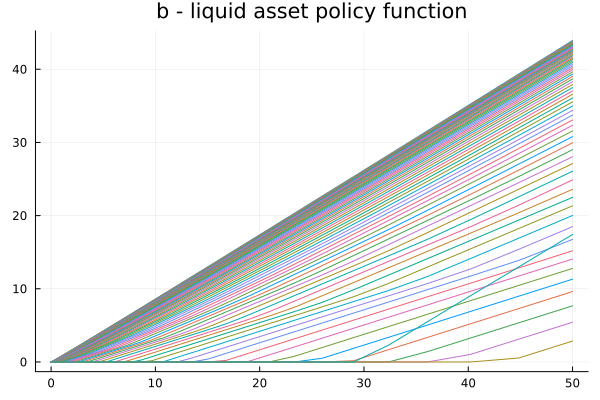

In [202]:
plot(b,b_pol[1,:,:], legend = false, title="b - liquid asset policy function")

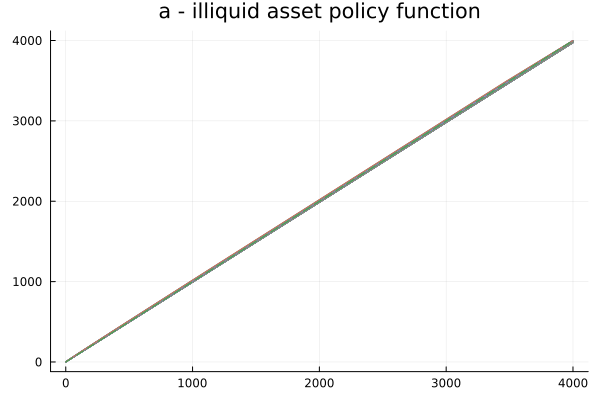

In [203]:
plot(a,a_pol[1,:,:]', legend = false, title="a - illiquid asset policy function" )
plot!(a,a, linestyle=:dash)

## Distribution matrices

Using lottery method by Young(2010)

In [190]:
PI_a = zeros(pr.nz, pr.nb, pr.na, pr.nz, pr.nb, pr.na)
for i in 1:pr.nz
    for j in 1:pr.nb
        for k in 1:pr.na
            policy = a_pol[i,j,k];
            indx = searchsortedlast(a, policy, lt= <)
            # write an if for indx== 0 or 70
            if indx==pr.na
                indx = indx - 1;
            end
            PI_a[i,j,k,:,:,indx]   .= (a[indx+1] - policy) / (a[indx+1]-a[indx])
            PI_a[i,j,k,:,:,indx+1] .= (policy - a[indx]) / (a[indx+1]-a[indx])
        end
    end
end

PI_b = zeros(pr.nz, pr.nb, pr.na, pr.nz, pr.nb, pr.na)
for i in 1:pr.nz
    for j in 1:pr.nb
        for k in 1:pr.na
            policy = b_pol[i,j,k];
            indx = searchsortedlast(b, policy, lt= <)
            # write an if for indx== 0 or 70
            if indx==pr.nb
                indx = indx - 1;
            end
            PI_b[i,j,k,:,indx,:]   .= (b[indx+1] - policy) / (b[indx+1]-b[indx])
            PI_b[i,j,k,:,indx+1,:] .= (policy - b[indx]) / (b[indx+1]-b[indx])
        end
    end
end

PI_z = zeros(pr.nz, pr.nb, pr.na, pr.nz, pr.nb, pr.na)
for i in 1:pr.nz
    for j in 1:pr.nb
        for k in 1:pr.na
            for indx in 1:pr.nz
                PI_z[i,j,k,indx,:,:] .= z_p[i,indx]
            end
        end
    end
end

PI = PI_a .* PI_b .* PI_z;
PI = sparse(reshape(PI, pr.nz * pr.nb * pr.na, :));

In [214]:
dist = zeros(pr.nz * pr.nb * pr.na)'
dist[1,10,1] = 1

@showprogress for i in 1:10000
    dist_new = dist * PI
    if maximum(abs.(dist_new - dist)) < 1e-9
        print("reach to stationary dist after ",i," iterations.")
        break
    end
    dist = copy(dist_new)
end
dist = dist ./ sum(dist)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


reach to stationary dist after 1875 iterations.

1×10500 Matrix{Float64}:
 0.000497872  1.72204e-5  1.48905e-7  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

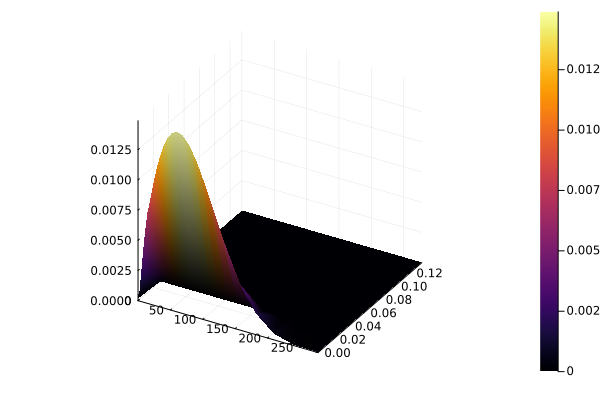

In [223]:
dist = reshape(dist, pr.nz, pr.nb, pr.na)

# draw first n = 20 first 
na = 51
nb = 5
surface(a[1:na], b[1:nb], dist[1,1:nb,1:na])

## mpc matrices